In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [10]:
# Load dataset
data = pd.read_csv("RS_GE/Runescape_Item_Prices.csv")

In [12]:
# Ensure 'price' is numeric
data['price'] = pd.to_numeric(data['price'], errors='coerce')

In [14]:
# Define max number of days on market (per the number of entries for the first item in the CSV file)
max_days = 5945

In [15]:
# Group data by stock 'id' and reset the index within each group
data = data.groupby('id').apply(lambda x: x.reset_index(drop=True))

In [17]:
# Initialize an empty list to store individual stock DataFrames
stock_dfs = []

# Get the list of unique stock IDs
stock_ids = data['id'].unique()

for stock_id in stock_ids:
    # Get data for the current stock
    stock_data = data[data['id'] == stock_id].reset_index(drop=True)
    
    # Create a DataFrame for the stock with the standard day index
    stock_day_index = pd.DataFrame({'day': np.arange(0, max_days)})
    
    # Merge the stock data with the standard day index
    stock_data_aligned = stock_day_index.merge(
        stock_data[['price']],
        left_index=True,
        right_index=True,
        how='left'
    )
    
    # Add the 'id' column
    stock_data_aligned['id'] = stock_id
    
    # Append to the list
    stock_dfs.append(stock_data_aligned)# Concatenate all stock DataFrames
aligned_data = pd.concat(stock_dfs, ignore_index=True)

# Pivot the data
data_pivot = aligned_data.pivot(index='day', columns='id', values='price')

# Handle missing values
data_pivot = data_pivot.fillna(method='ffill').fillna(method='bfill')
data_pivot = data_pivot.fillna(0)  # Ensure no remaining NaNs


In [21]:
# Concatenate all stock DataFrames
aligned_data = pd.concat(stock_dfs, ignore_index=True)

# Pivot the data 
data_pivot = aligned_data.pivot(index='day', columns='id', values='price')

# Handle missing values
data_pivot = data_pivot.fillna(method='ffill').fillna(method='bfill')
data_pivot = data_pivot.fillna(0) # Ensure no remaning NaNs

In [22]:
# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_pivot)
scaled_data = pd.DataFrame(scaled_data, columns=data_pivot.columns, index=data_pivot.index)

In [23]:
# Create sequences
def create_multivariate_dataset(data, time_steps=1):
    X, Y = [], []
    data_array = data.values
    for i in range(len(data_array) - time_steps):
        X.append(data_array[i:(i + time_steps), :])
        Y.append(data_array[i + time_steps, :])
    return np.array(X), np.array(Y)

time_steps = 60
X, Y = create_multivariate_dataset(scaled_data, time_steps)

In [24]:
# Split the data
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = Y[:train_size]
y_test = Y[train_size:]

In [25]:
# Build the model
n_features = X.shape[2]
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps, n_features)))
model.add(LSTM(50))
model.add(Dense(n_features))
model.compile(loss='mean_squared_error', optimizer='adam')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    verbose=1
)

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 28s 351ms/step - loss: 0.1149 - val_loss: 0.0554
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - loss: 0.0189 - val_loss: 0.0367
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - loss: 0.0116 - val_loss: 0.0319
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - loss: 0.0084 - val_loss: 0.0303
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 155ms/step - loss: 0.0069 - val_loss: 0.0294
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - loss: 0.0060 - val_loss: 0.0289
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - loss: 0.0055 - val_loss: 0.0302
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - loss: 0.0057 - val_loss: 0.0296
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - loss: 0.0055 - val_loss: 0.0295
Epoch 10/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - loss: 0.0051 - val_loss: 0.0296
Epoch 11/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - loss: 0.0046 - val_loss: 0.0290
Epoch 12/100
74/74 ━━━━━━━━━━━

In [28]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions and actual values
train_predict_inv = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train)
test_predict_inv = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test)

148/148 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [29]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv, multioutput='raw_values'))
stock_rmse = pd.DataFrame({
    'Stock': data_pivot.columns,
    'RMSE': rmse
})
print(stock_rmse)

      Stock           RMSE
0         2     381.336772
1        36     244.290227
2        39      13.155099
3        40      20.412196
4        41      24.699298
...     ...            ...
6180  53088       1.045186
6181  53093       1.128469
6182  53119     137.253907
6183  53207  359639.304335
6184  53209  216422.279594

[6185 rows x 2 columns]


In [39]:
# Sort the DataFrame by 'RMSE' in ascending order
stock_rmse_sorted = stock_rmse.sort_values(by='RMSE')

# Select the top 1000 stocks with the lowest RMSE
top_1000_stocks = stock_rmse_sorted.head(1000)

# Display the top 1000 stocks
print("Top 1000 Stocks with the Lowest RMSE:")
print(top_1000_stocks)

Top 1000 Stocks with the Lowest RMSE:
      Stock      RMSE
4849  45331  0.000000
5992  51769  0.000000
4847  45324  0.000000
4869  45401  0.000000
4867  45394  0.000000
...     ...       ...
979    3428  9.789998
1108   4361  9.794633
1539   6283  9.798019
5535  47697  9.829606
1491   6024  9.835935

[1000 rows x 2 columns]


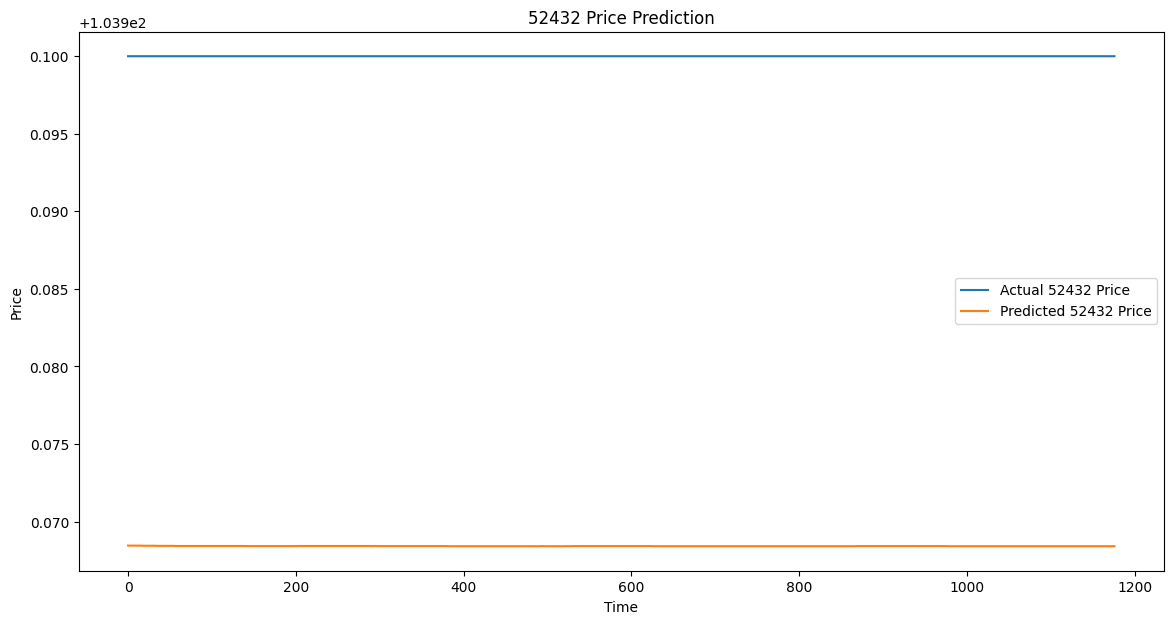

In [68]:
# Plot predictions for a selected stock
stock_index = 6092  # Change this index to plot different stocks
stock_name = data_pivot.columns[stock_index]
actual_prices = y_test_inv[:, stock_index]
predicted_prices = test_predict_inv[:, stock_index]

plt.figure(figsize=(14, 7))
plt.plot(actual_prices, label=f'Actual {stock_name} Price')
plt.plot(predicted_prices, label=f'Predicted {stock_name} Price')
plt.title(f'{stock_name} Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [59]:
# Script to retrieve item name based on id
def get_item_name(item_id):
    # Load the mapping file
    stock_names = pd.read_csv('RS_GE/Runescape_Item_Names.csv')
    
    # Ensure 'id' is of the same type as item_id
    stock_names['Name_ID'] = stock_names['Name_ID'].astype(str)
    item_id = str(item_id)
    
    # Retrieve the item name corresponding to the item_id
    item_name_row = stock_names[stock_names['Name_ID'] == item_id]
    
    if not item_name_row.empty:
        item_name = item_name_row.iloc[0]['Name']
        return item_name
    else:
        return f"Item with ID {item_id} not found."

item_id = 53209 # Change this as needed
item_name = get_item_name(item_id)
print(f"The name of the item with ID {item_id} is: {item_name}")

The name of the item with ID 53209 is: Rainbow glasses


In [67]:

# Assuming 'stock_rmse' DataFrame exists with columns 'Stock' (IDs) and 'RMSE'

# Load the mapping file
stock_names = pd.read_csv('RS_GE/Runescape_Item_Names.csv')

# Ensure 'id' and 'Stock' columns are of the same data type
stock_names['Name_ID'] = stock_names['Name_ID'].astype(str)
stock_rmse['Stock'] = stock_rmse['Stock'].astype(str)

# Merge 'stock_rmse' with 'stock_names' to get the stock names
stock_rmse_named = stock_rmse.merge(stock_names, left_on='Stock', right_on='Name_ID', how='left')

# Handle any missing names (optional)
stock_rmse_named['Name'] = stock_rmse_named['Name'].fillna('Unknown')

# Filter out stocks with RMSE equal to zero
stock_rmse_nonzero = stock_rmse_named[stock_rmse_named['RMSE'] > 0]

# Sort the DataFrame by 'RMSE' in ascending order
stock_rmse_sorted = stock_rmse_nonzero.sort_values(by='RMSE')

# Select the top 30 stocks with the lowest nonzero RMSE
top_30_stocks = stock_rmse_sorted.head(50) # Change this number as needed

# Display the top 30 stocks
print("Top 30 Stocks with the Lowest Nonzero RMSE:")
print(top_30_stocks[['Name', 'RMSE']])

Top 30 Stocks with the Lowest Nonzero RMSE:
                                                Name      RMSE
5492                       2/3 strawberry cheesecake  0.000053
5487                     Slice of vanilla cheesecake  0.000069
5489                        2/3 chocolate cheesecake  0.000092
5496                       Slice of lemon cheesecake  0.000206
5499                       Slice of bacon cheesecake  0.000244
5495                            2/3 lemon cheesecake  0.000336
5486                          2/3 vanilla cheesecake  0.000347
5493                  Slice of strawberry cheesecake  0.000378
5490                   Slice of chocolate cheesecake  0.000381
3548                                   Pigswill (m2)  0.000488
6078                           Raw fungal algae soup  0.000653
5997               Fractured stabilisation gem shard  0.000977
4182     A mis-fortune from The Mighty Zoltan (4/17)  0.001019
6074                       Raw calcified fungus soup  0.001333
5978       